# Diamond analysis

## Data cleaning

### importing libraries

In [196]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

### reading data

In [197]:
dataset = pd.read_csv('messy_data.csv', skipinitialspace=True)

# Print the size of the messy data
print('Size of messy data: %d' % len(dataset))

# Print column names
print('Column names: %s' % list(dataset.columns))

Size of messy data: 200
Column names: ['carat', 'clarity', 'color', 'cut', 'x dimension', 'y dimension', 'z dimension', 'depth', 'table', 'price']


### initial cleaning

In [198]:
# Strip leading/trailing spaces from column names
dataset.columns = dataset.columns.str.strip()

# clarity, color and cut should be uppercase
dataset['clarity'] = dataset['clarity'].str.upper()
dataset['color'] = dataset['color'].str.upper()
dataset['cut'] = dataset['cut'].str.upper()

# Rename columns x dimension, y dimension, and z dimension to length, width, and height
dataset = dataset.rename(columns={'x dimension': 'length', 'y dimension': 'width', 'z dimension': 'height'})

# Drop rows with missing price values
dataset.dropna(subset=['price'], inplace=True)

# Drop any duplicate rows
dataset.drop_duplicates(inplace=True)

# Print the size of the messy data
print('Size of clean data: %d' % len(dataset))

# Print column names
print('Column names: %s' % list(dataset.columns))

Size of clean data: 196
Column names: ['carat', 'clarity', 'color', 'cut', 'length', 'width', 'height', 'depth', 'table', 'price']


### write clean data to csv

In [199]:
# We do not want to deal with missing values yet
clean_data = dataset.copy()
clean_data.to_csv('clean_data.csv', index=False)

### identifying missing data

In [200]:

missingValues = dataset.isnull().sum()
print("Missing values: \n", missingValues, "\n")

print("In total, there were", missingValues.sum(), "missing values in the dataset.", "\n")

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')

# Fit on columns: carat, length, width, height, depth, and table
imputer.fit(dataset[['carat', 'length', 'width', 'height', 'depth', 'table']])

# Transform columns: carat, length, width, height, depth, and table
dataset[['carat', 'length', 'width', 'height', 'depth', 'table']] = imputer.transform(dataset[['carat', 'length', 'width', 'height', 'depth', 'table']])

print("After imputation, there are", dataset.isnull().sum().sum(), "missing values in the dataset.")



Missing values: 
 carat      48
clarity     0
color       0
cut         0
length      2
width      64
height     46
depth      67
table      32
price       0
dtype: int64 

In total, there were 259 missing values in the dataset. 

After imputation, there are 0 missing values in the dataset.


## Split the features and dependent variable

In [201]:
# Split out the features and dependent variable
X = dataset.drop('price', axis=1)
y = dataset['price']

## Visualizations

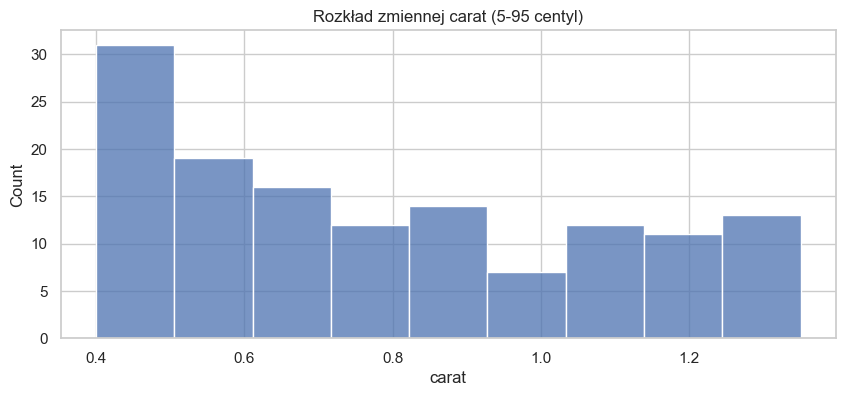

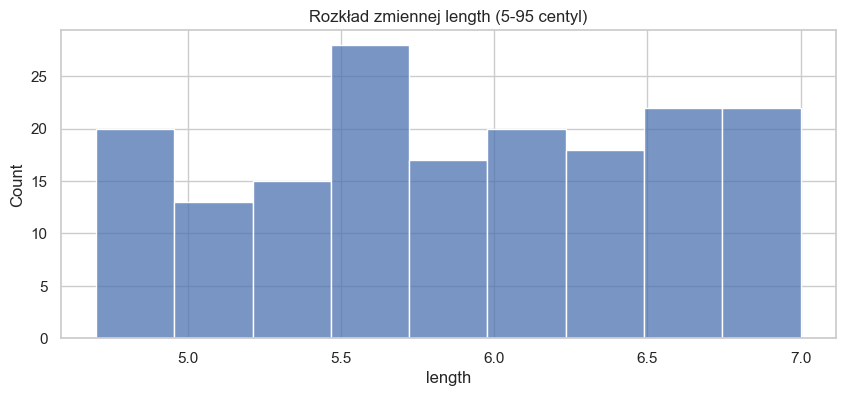

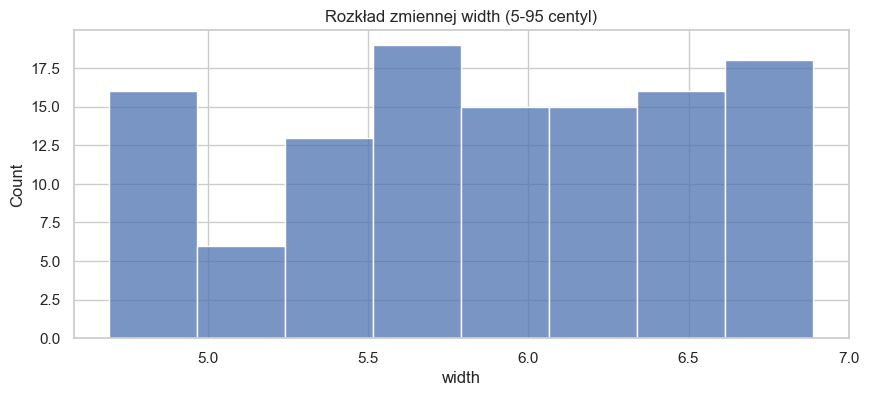

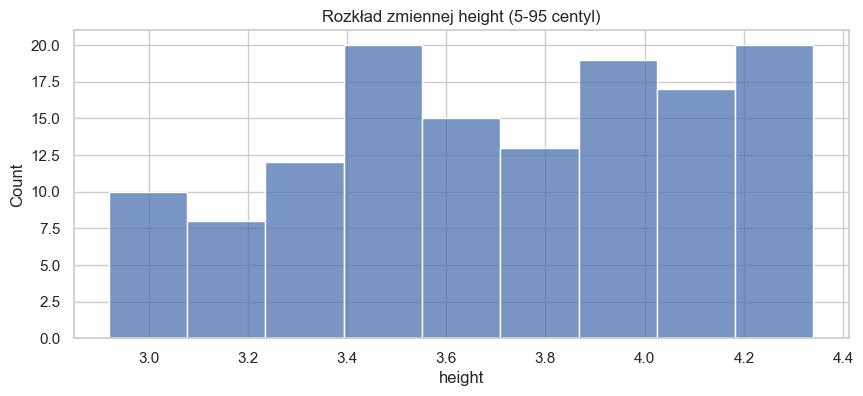

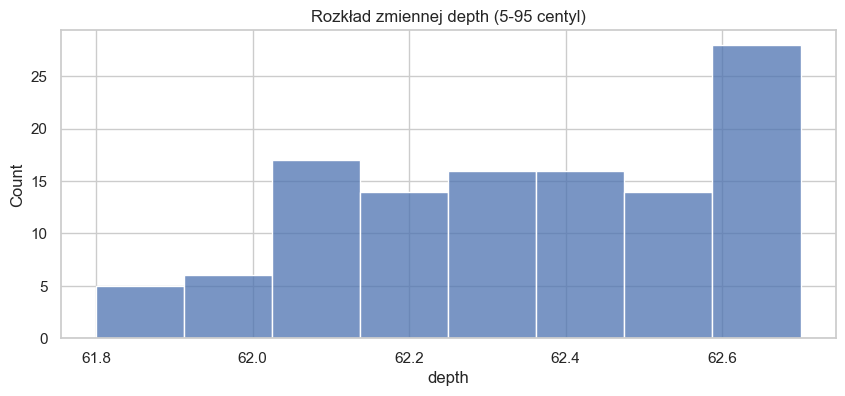

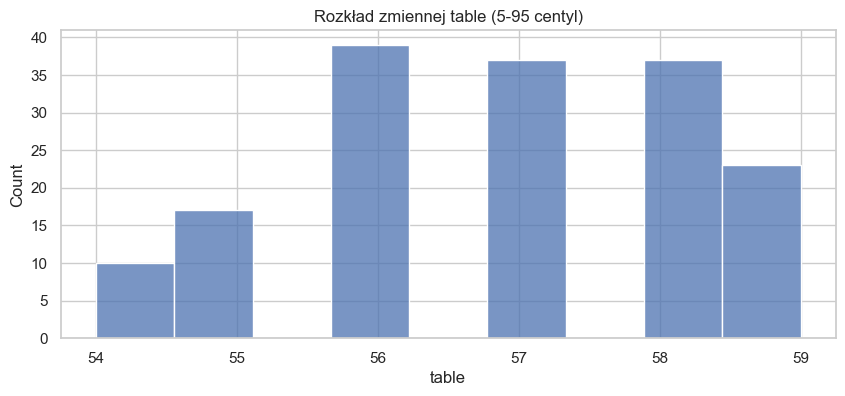

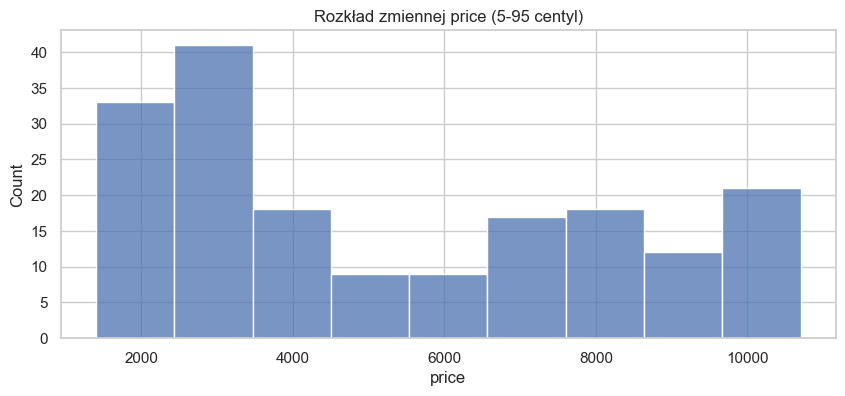

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns
# Ustawienie stylu wykresów
sns.set(style="whitegrid")

def plot_histplot(data, col):
    plt.figure(figsize=(10, 4))
    sns.histplot(data[col])
    plt.title(f'Rozkład zmiennej {col}')
    plt.show()

# Histogramy dla zmiennych ciągłych z odrzuceniem wartości odstających
continuous_vars = ['carat', 'length', 'width', 'height', 'depth', 'table', 'price']
for col in continuous_vars:
    # Obliczenie 5. i 95. centyla
    lower_bound, upper_bound = clean_data[col].quantile(0.05), clean_data[col].quantile(0.95)

    # Ograniczenie danych do wartości wewnątrz granic centyli
    filtered_data = clean_data[(clean_data[col] >= lower_bound) & (clean_data[col] <= upper_bound)]

    # Tworzenie histogramu dla przefiltrowanych danych
    plt.figure(figsize=(10, 4))
    sns.histplot(filtered_data[col])
    plt.title(f'Rozkład zmiennej {col} (5-95 centyl)')
    plt.show()